### Set up working directory

In [ ]:
# ONLY RUN THIS BLOCK IF TORCH-EVIDENTAL-DEEP-LEARNING IS PRIVATE
!ssh-keygen -t rsa -b 4096 # keep all answers to default (empty)
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

# add the new public ssh key to Github
# instructions on adding ssh key: https://docs.github.com/en/github/authenticating-to-github/connecting-to-github-with-ssh/adding-a-new-ssh-key-to-your-github-account
!echo '---------------------------------------------'
!cat /root/.ssh/id_rsa.pub

In [ ]:
# ONLY RUN THIS BLOCK IF TORCH-EVIDENTAL-DEEP-LEARNING IS PRIVATE
!ssh -T git@github.com

In [13]:
%cd /content/
!git clone git@github.com:hxu296/torch-evidental-deep-learning
%cd /content/torch-evidental-deep-learning

/content
Cloning into 'torch-evidental-deep-learning'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 41 (delta 7), reused 32 (delta 5), pack-reused 0
Receiving objects: 100% (41/41), 73.52 KiB | 14.70 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/torch-evidental-deep-learning


### Demo: curve fitting

epoch: 1, loss: 9.164384841918945
epoch: 100, loss: 3.96213960647583
epoch: 200, loss: 3.7168290615081787
epoch: 300, loss: 3.4722230434417725
epoch: 400, loss: 3.1317365169525146
epoch: 500, loss: 2.8914074897766113


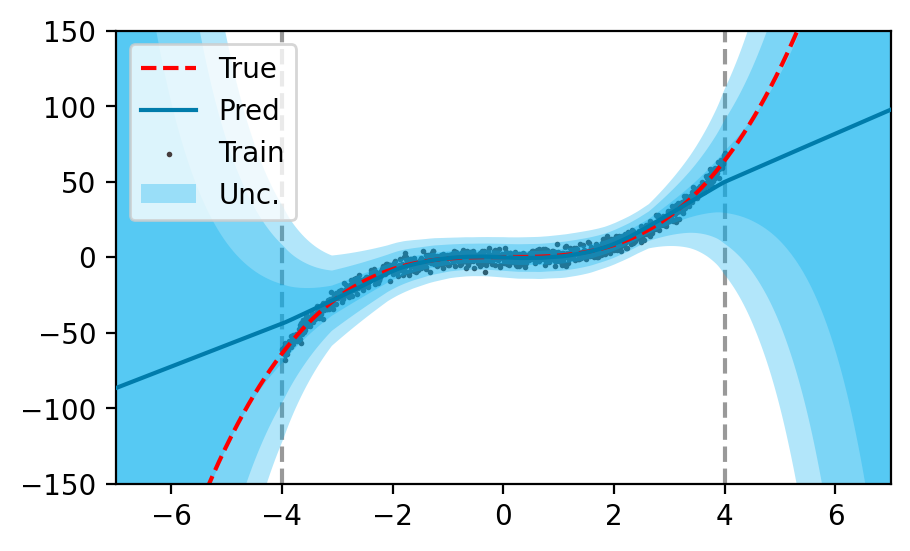

In [15]:
import functools
import numpy as np
import matplotlib.pyplot as plt
import evidential_deep_learning as edl
import torch
import torch.nn as nn

def main():
    # Create some training and testing data
    x_train, y_train = my_data(-4, 4, 1000)
    x_test, y_test = my_data(-7, 7, 1000, train=False)

    # Define our model with an evidential output
    model = nn.Sequential(
        nn.Linear(x_train.shape[-1], 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        edl.layers.DenseNormalGamma(64, 1),
    )

    # Custom loss function to handle the custom regularizer coefficient
    def EvidentialRegressionLoss(true, pred):
        return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

    # Compile and fit the model!
    opt = torch.optim.Adam(model.parameters())
    for t in range(500):
        opt.zero_grad()
        y_pred = model(x_train)   #x is tensor of independent vars
        loss = EvidentialRegressionLoss(y_train, y_pred) #y is tensor of outcomes
        loss.backward()
        opt.step()
        if not (t+1) % 100 or t == 0: print('epoch: {0}, loss: {1}'.format(t+1, loss))

    # Predict and plot using the trained model
    y_pred = model(x_test)
    plot_predictions(x_train.detach().numpy(),
                     y_train.detach().numpy(),
                     x_test.detach().numpy(),
                     y_test.detach().numpy(),
                     y_pred.detach().numpy())

    # Done!!


#### Helper functions ####
def my_data(x_min, x_max, n, train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)

    sigma = 3 * np.ones_like(x) if train else np.zeros_like(x)
    y = x**3 + np.random.normal(0, sigma).astype(np.float32)

    return torch.Tensor(x), torch.Tensor(y)

def plot_predictions(x_train, y_train, x_test, y_test, y_pred, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    mu, v, alpha, beta = np.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.linspace(0, n_stds, 4):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()


if __name__ == "__main__":
    main()
